<a href="https://colab.research.google.com/github/yupopov/stepik-dl-cv/blob/main/module04_mnist_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification by a fully connected network

In this notebook we construct a fully connected network with two hidden layers for the MNIST dataset, and then see how its quality and training time are affected by its learning parameters (such as number of epochs, batch size, and an optimizer).

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Let's load the dataset.

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [ ]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

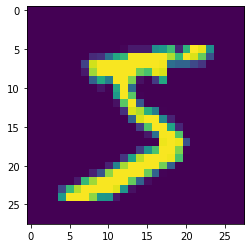

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_test = X_test.to(device)
y_test = y_test.to(device);

The network class and the training function can be found below:

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100).to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
# !nvidia-smi

In [ ]:
def train_net(optimizer_params, n_hidden_neurons=100, batch_size=100, n_epochs=200, optimizer=torch.optim.Adam):
    batch_size = batch_size

    mnist_net = MNISTNet(n_hidden_neurons).to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = optimizer(mnist_net.parameters(), **optimizer_params)

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []


    for epoch in range(n_epochs):
        order = np.random.permutation(len(X_train))
        train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float)
        train_batch_loss_history = []
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size]
            
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            
            preds_batch = mnist_net.forward(X_batch) 
            
            loss_value = loss(preds_batch, y_batch)
            loss_value.backward()
            
            train_batch_loss_history.append(loss_value.tolist())
            train_preds[batch_indexes] = preds_batch.cpu()

            optimizer.step()

        with torch.no_grad():
          test_preds = mnist_net.forward(X_test)
          test_loss = loss(test_preds, y_test).cpu()
          test_loss_history.append(test_loss)
          
          test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
          test_accuracy_history.append(test_accuracy)

          train_loss = np.mean(train_batch_loss_history)
          train_loss_history.append(train_loss)
          
          train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().cpu()
          train_accuracy_history.append(train_accuracy)

    return test_loss_history, test_accuracy_history, train_loss_history, train_accuracy_history

## 1. Plot the train and the test losses on the same graph

We plot the accuracies as well.

In [ ]:
test_loss_history, test_accuracy_history, train_loss_history, train_accuracy_history = train_net(optimizer_params={'lr': 1e-3}, n_epochs=200)

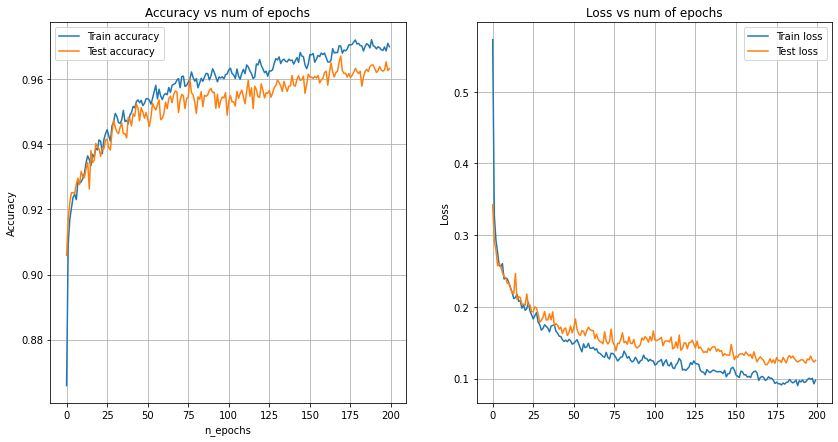

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(train_accuracy_history, label='Train accuracy')
ax[0].plot(test_accuracy_history, label='Test accuracy')
ax[0].grid(True)
ax[0].legend(loc='best')
ax[0].set_xlabel('n_epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs num of epochs')

ax[1].plot(train_loss_history, label='Train loss')
ax[1].plot(test_loss_history, label='Test loss')
ax[1].grid(True)
ax[1].legend(loc='best')
ax[0].set_xlabel('n_epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss vs num of epochs');

*Do the train and validation losses decrease equally fast and reaches the same value, or do we have overfitting here?*

One can see the model overfits slightly to the train set (however, the test accuracy doesn't decrease, so our network can still generalize well to unknown data).

*Does increasing the number of epochs (40 epochs -> 200 epochs) improve the validation metrics?*

We see that both the accuracy and the loss improve until around epoch #175, and start plateauing afterwards.

## 2. Measure the calculation time of 100 epochs on CPU and on GPU. How much acceleration can you achieve?

We train the model five times on GPU for each `batch_size` = $2^k, \ k = 6, \ldots, 13$ and save the average train times. We record the average test accuracy histories for each batch size as well.

In [ ]:
from time import time

In [ ]:
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]
train_times_gpu = []
test_accuracy_histories = []
for batch_size in batch_sizes:
    train_times_ = [] 
    accuracy_histories_ = []
    for i in range(5): # Train 5 nets with different random seeds
        random.seed(i)
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed(i)

        time1 = time()
        _, test_accuracy_history, _, _ = train_net(optimizer_params={'lr': 1e-3}, batch_size=batch_size, n_epochs=100)
        time2 = time()
        train_times_.append(time2 - time1)
        accuracy_histories_.append(test_accuracy_history)

    train_times_ = np.array(train_times_)
    train_times_gpu.append(train_times_.mean())

    accuracy_histories_ = np.array(accuracy_histories_)
    test_accuracy_histories.append(accuracy_histories_.mean(axis=0))

In [ ]:
device = torch.device('cpu')
X_test = X_test.to(device)
y_test = y_test.to(device);

Training the model on CPU multiple times would take too much time, so here we train the neural network only once for each batch size.

In [ ]:
train_times_cpu = []
for batch_size in batch_sizes:
    time1 = time()
    _ = train_net(optimizer_params={'lr': 1e-3}, batch_size=batch_size, n_epochs=100)
    time2 = time()
    train_times_cpu.append(time2 - time1)

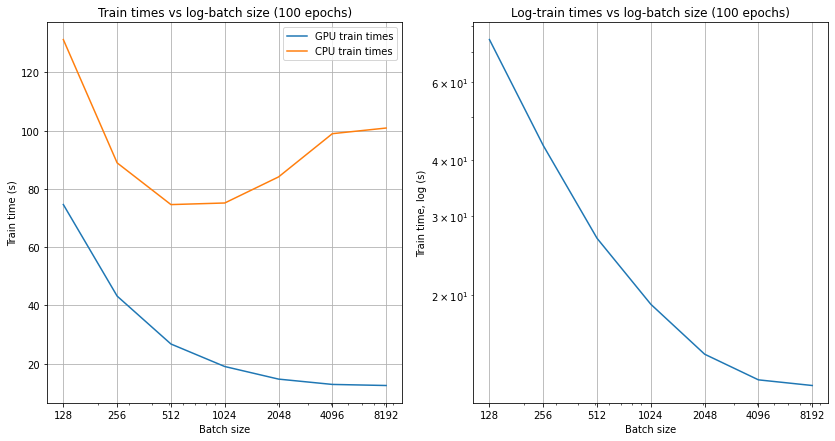

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].semilogx(batch_sizes, train_times_gpu, label='GPU train times')
ax[0].semilogx(batch_sizes, train_times_cpu, label='CPU train times')
ax[0].set_xticks(batch_sizes)
ax[0].set_xticklabels(batch_sizes)
ax[0].set_xlabel('Batch size')
ax[0].set_ylabel('Train time (s)')
ax[0].set_title('Train times vs log-batch size (100 epochs)')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].set_title('Log-train times vs log-batch size (100 epochs)')
ax[1].loglog(batch_sizes, train_times_gpu, label='GPU train times')
ax[1].set_xticks(batch_sizes)
ax[1].set_xticklabels(batch_sizes)
ax[1].set_xlabel('Batch size')
ax[1].set_ylabel('Train time, log (s)')
ax[1].grid(True);

We see that we achieve the best train time on CPU with `batch_size=512`, and after that the train time starts to increase.

The train times on GPU decrease linearly with respect to the batch size up until `batch_size=1024`, and after that the decrease rate drops.

Overall, we have about 5-6x acceleration using GPU.

Now let's plot the test accuracy histories for each batch size:

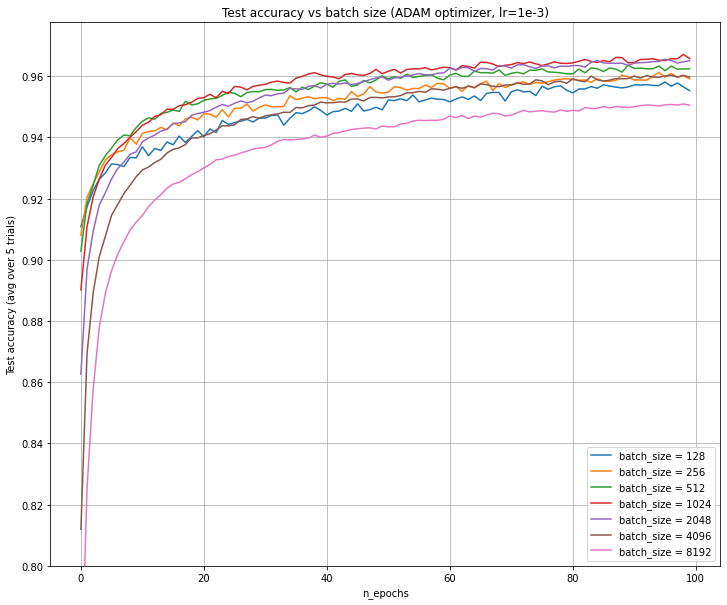

In [ ]:
plt.figure(figsize=(12, 10))
for ix, batch_size in enumerate(batch_sizes):
  plt.plot(test_accuracy_histories[ix], label=f'batch_size = {batch_size}')
plt.ylim(bottom=0.8)
plt.xlabel('n_epochs')
plt.ylabel('Test accuracy (avg over 5 trials)')
plt.title('Test accuracy vs batch size (ADAM optimizer, lr=1e-3)')
plt.grid(True)
plt.legend();

We see that we achieve the best results with `batch_size` equal to 1024 or 2048, and too small (128) or too big (8192) batch size gives worse quality (perhaps the batch size can be interpreted as the learning rate as well?).

## 3. Does setting `torch.backends.cudnn.deterministic = True` slow learning?

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
torch.backends.cudnn.deterministic = False
train_times_gpu_nondet = []
for batch_size in batch_sizes:
    time1 = time()
    _ = train_net(optimizer_params={'lr': 1e-3}, batch_size=batch_size, n_epochs=100)
    time2 = time()
    train_times_gpu_nondet.append(time2 - time1)

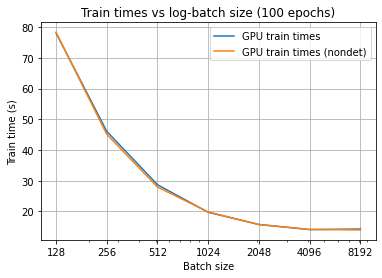

In [ ]:
plt.semilogx(batch_sizes, train_times_gpu, label='GPU train times')
plt.semilogx(batch_sizes, train_times_gpu_nondet, label='GPU train times (nondet)')
plt.xticks(batch_sizes, labels=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.title('Train times vs log-batch size (100 epochs)')
plt.legend(loc='best')
plt.grid(True)

So changing this parameter doesn't really affect the learning speed.

In [ ]:
torch.backends.cudnn.deterministic = True

## 4. Try different gradient descent optimizers. How does the choice of a gradient descent method affect the accuracy?

We try Adam, SGD, RMSProp and Rprop optimizers with different parameters (learning rates and momentums). For every optimizer we run 5 trials with different random seeds.



In [ ]:
adam_accuracies = []
sgd_accuracies = []
rmsprop_accuracies = []
rprop_accuracies = []


for i in range(5):
  random.seed(i)
  np.random.seed(i)
  torch.manual_seed(i)
  torch.cuda.manual_seed(i)

  _, test_accuracy_history, _, _  = train_net(batch_size=2048, optimizer_params={'lr': 1e-3}, n_epochs=200)
  adam_accuracies.append(test_accuracy_history)

  _, test_accuracy_history, _, _  = train_net(batch_size=2048, optimizer=torch.optim.SGD,
                                              optimizer_params={'lr': 1e-1, 'momentum': 0.1}, n_epochs=200)
  sgd_accuracies.append(test_accuracy_history)

  _, test_accuracy_history, _, _  = train_net(batch_size=2048, optimizer=torch.optim.RMSprop,
                                              optimizer_params={'lr': 1e-3}, n_epochs=200)
  rmsprop_accuracies.append(test_accuracy_history)

  _, test_accuracy_history, _, _  = train_net(batch_size=2048, optimizer=torch.optim.Rprop,
                                              optimizer_params={'lr': 1e-2}, n_epochs=200)
  rprop_accuracies.append(test_accuracy_history)
  
adam_accuracy = torch.Tensor(adam_accuracies).cpu().numpy().mean(axis=0)
sgd_accuracy = torch.Tensor(sgd_accuracies).cpu().numpy().mean(axis=0)
rmsprop_accuracy = torch.Tensor(rmsprop_accuracies).cpu().numpy().mean(axis=0)
rprop_accuracy = torch.Tensor(rprop_accuracies).cpu().numpy().mean(axis=0)

We found the following:

- SGD with `lr = 1e-2` learns too slow, changing learning rate to 0.1 and adding `momentum=0.1` helps;
- RMSprop with the default learning rate ($10^{-2}$) stops improving fast, changing the learning rate to 0.001 we get accuracy similar to Adam's;
- Rprop stops learning fast and doesn't achieve great accuracy for all learning rates that we tried.

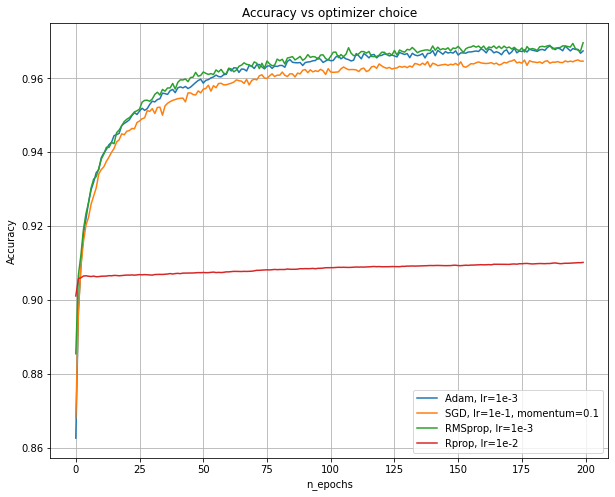

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(adam_accuracy, label='Adam, lr=1e-3')
plt.plot(sgd_accuracy, label='SGD, lr=1e-1, momentum=0.1')
plt.plot(rmsprop_accuracy, label='RMSprop, lr=1e-3')
plt.plot(rprop_accuracy, label='Rprop, lr=1e-2')
plt.xlabel('n_epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs optimizer choice')
plt.legend(loc='best')
plt.grid(True);